### 모델 결과 해석

- 최종 모델 XGBoost(임계값 0.4 + 베이지안 최적화) 
    - 실제 결제 전환 가능성 있는 유저를 예측하는데에 초점을 맞춘 모델 
    - 예측된 결제 전환 가능성 높은 유저에 마케팅 비용을 집중하는데 모델 활용 가능

### 클러스터링 결과 해석

- `cluster0` : 유료 결제 전환율 보통 그룹(장기 체류 탐색형 고객)
    - 특징: 체류 시간 가장 김, 2.2일 방문, 입실 횟수 5회, 100평, 한 번 방문 시 장시간 체류 -> 관심도는 높음
    - 일부 유저 여러 지점 체험(지점 비교 후 결제 결정 가능성)
    - 마케팅 전략: 의사결정 지연 고민 해소
        - 각 지점별 정보가 담긴 지점 비교 가이드 제공
        - 장시간 이용자용 할인 요금제
        - 지점별 후기 정보 제공
- `cluster1` : 유료 결제 전환율 가장 낮은 그룹(단순 체험 고객)
    - 특징: 하루만 체험, 3일 중 1일만 방문, 체류 시간 짧음, 출입 빈도 적음 
    - 짧게 방문 후 이탈하는 경향
        - 단순 체험 방문
    - 마케팅 전략: 저비용 채널 활용 재방문 유도 리마인드
        - 체험 기한 리마인드 푸시
        - 다른 공간 체험 제안  
- `cluster2`: 유료 결제 전환율 가장 높은 그룹(체험 충실형 고객) - 핵심 타겟
    - 특징: 출입 빈도 높음, 체류 시간 긴 편, 단일 지점 방문, 1회 방문 시 꽤 오래 체류, 넓은 공간 선호
    - 3일 체험을 적극 활용하며 넓은 공간 선호하는 유저는 결제 전환율이 높은 경향 -> 사용 목적 가장 뚜렷, 
    - 마케팅 전략: 쾌적한 환경 및 3일 체험 시 혜택
        - 3일 체험 모두 방문 시 장기 요금제 프로모션
        - 프리미엄 좌석 및 프라이빗 룸 소개 

## 4. 모델링

In [18]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import koreanize_matplotlib

In [19]:
data_path= '/Users/SongKG/Documents/codeit_study/중급프로젝트2(06/09~)/user_summary_final.csv'
data_path2='/Users/SongKG/Documents/codeit_study/중급프로젝트2(06/09~)/access_log_final_df.csv'
user_summary_df = pd.read_csv(data_path)
access_log_final_df = pd.read_csv(data_path2)

In [20]:
user_summary_df = user_summary_df.rename({'session_count_x': 'session_count'})

In [21]:
print(user_summary_df.shape)
print(user_summary_df.info())

(5707, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 5707 entries, 0 to 5706
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_uuid              5707 non-null   object 
 1   total_stay_time        5707 non-null   int64  
 2   avg_stay_time          5707 non-null   float64
 3   visit_days             5707 non-null   int64  
 4   visited_sites_count    5707 non-null   int64  
 5   session_count          5707 non-null   int64  
 6   first_visit_month      5707 non-null   object 
 7   first_visit_time_band  5707 non-null   object 
 8   days_since_trial       5707 non-null   int64  
 9   area_pyeong            5707 non-null   int64  
 10  is_payment             5707 non-null   int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 535.0+ KB
None


#### 모델링 피쳐 후보

- `first_visit_time_band` : 첫 방문 시간대
- `first_visit_month` : 첫 방문 월
- `days_to_payment` : 결제까지 걸린 일수
- `total_stay_time` : 총 체류 시간 
- `avg_stay_time` : 평균 체류 시간 
- `visit_days` : 방문 일수 
- `visited_sites_count` : 방문 지점 개수(여러 지점 방문할수록 유료 결제 전환율이 올라가는가?)
- `session_count` : 입실 횟수(출입 빈도 보기 위함)
- `area_pyeong` : 첫 방문 지점 면적 

### 4-1 범주형 데이터 전처리(첫 방문 시간대) - 원핫인코딩


In [22]:
user_df = pd.get_dummies(user_summary_df, columns=['first_visit_time_band'], prefix='visit_time',dtype=int)
user_df.tail(2)
user_df.shape

(5707, 14)

In [23]:
len(user_summary_df['first_visit_month'].unique())

33

In [24]:
user_df['first_visit_month'] = pd.to_datetime(user_df['first_visit_month'])

user_df['visit_month'] = user_df['first_visit_month'].dt.month

In [25]:
user_df.drop(columns='first_visit_month', inplace=True)

In [26]:
user_df = user_df.rename(columns={'visit_month' :'first_visit_month'})

In [27]:
user_summary_df.describe().T

,count,mean,std,min,25%,50%,75%,max
total_stay_time,5707.0,29971.822323,25614.484166,9.0,10904.5,22548.0,42368.0,249203.0
avg_stay_time,5707.0,15664.571783,10113.489133,9.0,8246.5,14354.0,21217.0,81464.0
visit_days,5707.0,1.787104,0.820814,1.0,1.0,2.0,2.0,4.0
visited_sites_count,5707.0,1.056422,0.262718,1.0,1.0,1.0,1.0,4.0
session_count,5707.0,4.993517,4.387407,1.0,2.0,4.0,7.0,40.0
days_since_trial,5707.0,0.922026,3.443152,-1.0,0.0,1.0,1.0,201.0
area_pyeong,5707.0,111.091642,42.151021,50.0,50.0,100.0,150.0,150.0
is_payment,5707.0,0.390573,0.487922,0.0,0.0,0.0,1.0,1.0


### 4-2 베이스라인 모델 - RandomForest


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [29]:
X = user_df.drop(columns=['user_uuid','is_payment'])
y = user_df['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4565, 12)
(4565,)
(1142, 12)


In [30]:
rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=2025)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)
acc_rf = accuracy_score(y_test, rf_pred)

In [31]:
print(f'랜덤 포레스트 모델 정확도: {acc_rf:.3f}')

랜덤 포레스트 모델 정확도: 0.598


In [32]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

[[513 183]
 [276 170]]
              precision    recall  f1-score   support

           0       0.65      0.74      0.69       696
           1       0.48      0.38      0.43       446

    accuracy                           0.60      1142
   macro avg       0.57      0.56      0.56      1142
weighted avg       0.58      0.60      0.59      1142



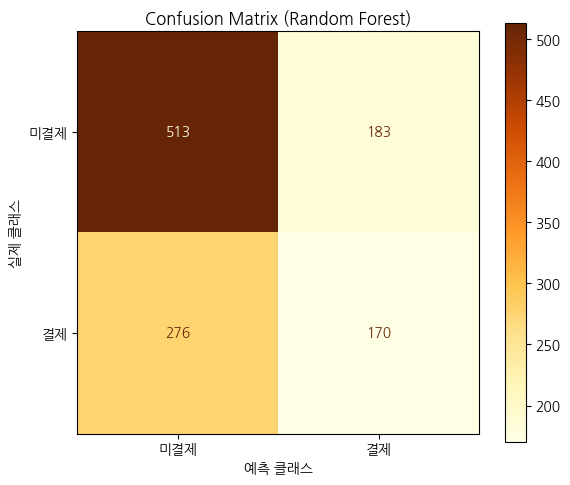

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# 1. confusion matrix 계산
cm = confusion_matrix(y_test, rf_pred)

# 2. 클래스 이름 설정 (0: 미결제, 1: 결제 등)
class_names = ['미결제', '결제']  # 필요 시 수정

# 3. 시각화 객체 생성
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 4. 시각화 출력
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='YlOrBr')  # 색상은 자유롭게 변경 가능
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.grid(False)
plt.tight_layout()
plt.show()


### 4-2.1 랜덤포레스트 - 베이지안 최적화

In [34]:
from bayes_opt import BayesianOptimization
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# 1. 목적 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split):
    rf = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        n_jobs=-1,
        random_state=2025
    )
    
    # 5-fold cross validation에서 평균 F1 score 계산 (또는 'roc_auc', 'accuracy' 등도 가능)
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall').mean()
    return score

# 2. 탐색할 하이퍼파라미터 범위 설정
pbounds = {
    'n_estimators': (100, 500),
    'max_depth': (3, 15),
    'min_samples_split': (2, 20)
}

# 3. 최적화 객체 정의
optimizer = BayesianOptimization(
    f=rf_cv,
    pbounds=pbounds,
    random_state=2025,
    verbose=2
)

# 4. 최적화 실행
optimizer.maximize(
    init_points=5,  # 초기 랜덤 탐색 횟수
    n_iter=15       # 이후 베이지안 방식으로 탐색할 횟수
)


|   iter    |  target   | n_esti... | max_depth | min_sa... |
-------------------------------------------------------------
| 2         | 0.3112721 | 154.19526 | 13.654220 | 18.786901 |
| 3         | 0.2804173 | 278.22726 | 7.6588265 | 6.6367358 |
| 4         | 0.2910789 | 362.94703 | 8.9114032 | 19.356291 |
| 5         | 0.2871510 | 420.39378 | 8.4624634 | 16.419045 |
| 6         | 0.3084694 | 116.68718 | 12.233494 | 2.0570801 |
| 7         | 0.0830233 | 181.55684 | 3.0       | 2.0       |
| 8         | 0.3163157 | 152.68965 | 14.158473 | 18.465130 |
| 9         | 0.0830217 | 129.34482 | 3.0       | 20.0      |
| 10        | 0.3438312 | 101.51117 | 15.0      | 2.0       |
| 11        | 0.1026531 | 100.0     | 3.0       | 2.0       |
| 12        | 0.3320429 | 108.26437 | 15.0      | 7.3403998 |
| 13        | 0.3382069 | 152.38083 | 15.0      | 5.3065631 |
| 14        | 0.0768514 | 152.37589 | 3.0       | 6.7298319 |
| 15        | 0.3348393 | 100.0     | 15.0      | 11.600987 |
| 16    

In [35]:
print("최적 결과:", optimizer.max)

최적 결과: {'target': 0.34664180278853113, 'params': {'n_estimators': 141.92169981429421, 'max_depth': 15.0, 'min_samples_split': 2.0}}


In [36]:
# 1. 최적 하이퍼파라미터 확인
best_params = optimizer.max['params']

# 2. 정수형으로 변환 (주의: bayesian-optimization은 float로 반환됨)
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_min_samples_split = int(best_params['min_samples_split'])

In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

# 3. 최적 파라미터로 모델 훈련
best_rf = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    n_jobs=-1,
    random_state=2025
)
best_rf.fit(X_train, y_train)

# 4. 예측
y_pred = best_rf.predict(X_test)

# 5. 성능 평가
print("🔹 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\n🔹 Classification Report:")
print(classification_report(y_test, y_pred))

🔹 Confusion Matrix:
[[531 165]
 [289 157]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70       696
           1       0.49      0.35      0.41       446

    accuracy                           0.60      1142
   macro avg       0.57      0.56      0.55      1142
weighted avg       0.59      0.60      0.59      1142



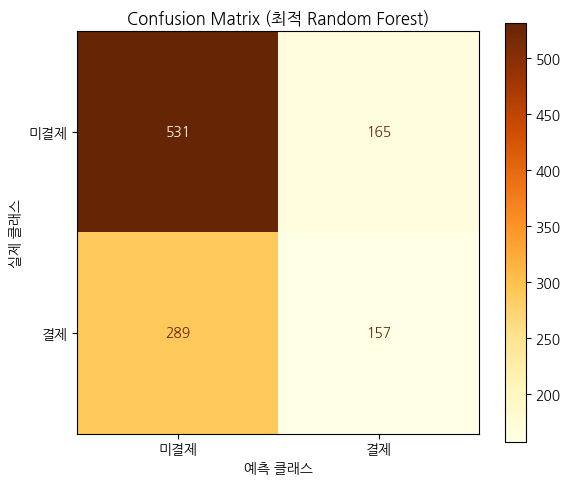

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 클래스 라벨 (필요에 따라 수정)
class_names = ['미결제', '결제']  # 0, 1이면 이렇게 사용 가능

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# 그림 설정
fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='YlOrBr')  # 컬러맵은 자유롭게 (예: 'Blues', 'BuGn', 'YlGnBu')
plt.title('Confusion Matrix (최적 Random Forest)')
plt.xlabel('예측 클래스')
plt.ylabel('실제 클래스')
plt.grid(False)
plt.tight_layout()
plt.show()


### 4-2.2 랜덤포레스트 변수 중요도 확인

In [39]:
best_rf.feature_importances_

array([0.25632641, 0.26356068, 0.05867636, 0.01465118, 0.12970179,
       0.05191755, 0.04977725, 0.01372192, 0.01326948, 0.00766774,
       0.00440738, 0.13632226])

In [40]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

avg_stay_time          0.263561
total_stay_time        0.256326
first_visit_month      0.136322
session_count          0.129702
visit_days             0.058676
days_since_trial       0.051918
area_pyeong            0.049777
visited_sites_count    0.014651
visit_time_심야          0.013722
visit_time_아침          0.013269
visit_time_오후          0.007668
visit_time_저녁          0.004407
dtype: float64

In [41]:
top_n = 10 
top_importances = importances.head(10)

<Axes: >

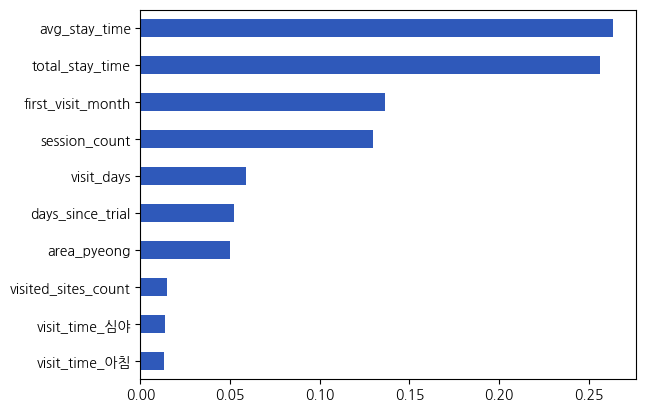

In [42]:
# 역순으로 그려서 가장 큰 값이 위로 가도록 설정
top_importances.iloc[::-1].plot(kind='barh', color="#2f59ba")

### 4-2.3 threshold별 recall-precision 변화 시각화

- threshold가 낮아질수록 recall 지표가 상승함
- 유료 결제자를 잘 예측하는 것이 목적
    - precision보다 recall이 중요 지표 -> recall 중심으로 개선!

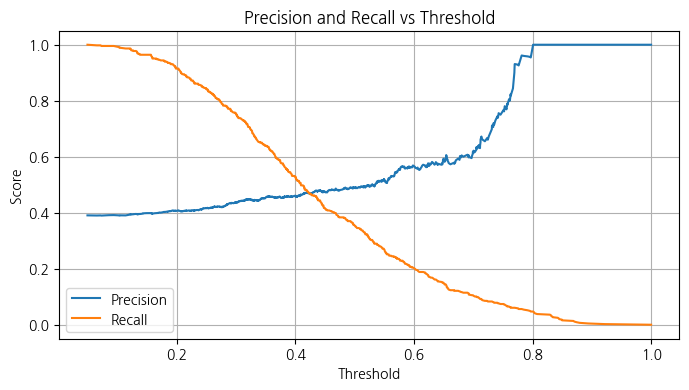

In [43]:
from sklearn.metrics import precision_recall_curve 

y_scores = best_rf.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
thresholds = list(thresholds) + [1.0] # 길이 맞추기

plt.figure(figsize=(8,4))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
# threshold = 0.4 실험
# 1. 예측 확률 얻기 (결제자 클래스 확률)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # 클래스 1(결제자)에 대한 확률

# 2. threshold 0.4 적용
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

In [46]:
from sklearn.metrics import classification_report
print('threshold: 0.4 결과 \n')
print(classification_report(y_test, y_pred_threshold))

threshold: 0.4 결과 

              precision    recall  f1-score   support

           0       0.67      0.60      0.63       696
           1       0.46      0.53      0.49       446

    accuracy                           0.57      1142
   macro avg       0.56      0.57      0.56      1142
weighted avg       0.59      0.57      0.58      1142



### 4-3 XGBoost

In [ ]:
!pip install xgboost

In [47]:
from xgboost import XGBClassifier

xb = XGBClassifier(eval_metric = 'logloss',random_state=2025)

xb.fit(X_train, y_train)

xb_pred = xb.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, xb_pred))
print("\nClassification Report:\n", classification_report(y_test, xb_pred))
print("\nAccuracy:", accuracy_score(y_test, xb_pred))

Confusion Matrix:
 [[534 162]
 [283 163]]

Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.77      0.71       696
           1       0.50      0.37      0.42       446

    accuracy                           0.61      1142
   macro avg       0.58      0.57      0.56      1142
weighted avg       0.59      0.61      0.60      1142


Accuracy: 0.6103327495621717


#### 하이퍼파라미터 튜닝 - XGBoost

In [48]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5707 entries, 0 to 5706
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_uuid            5707 non-null   object 
 1   total_stay_time      5707 non-null   int64  
 2   avg_stay_time        5707 non-null   float64
 3   visit_days           5707 non-null   int64  
 4   visited_sites_count  5707 non-null   int64  
 5   session_count        5707 non-null   int64  
 6   days_since_trial     5707 non-null   int64  
 7   area_pyeong          5707 non-null   int64  
 8   is_payment           5707 non-null   int64  
 9   visit_time_심야        5707 non-null   int64  
 10  visit_time_아침        5707 non-null   int64  
 11  visit_time_오후        5707 non-null   int64  
 12  visit_time_저녁        5707 non-null   int64  
 13  first_visit_month    5707 non-null   int32  
dtypes: float64(1), int32(1), int64(11), object(1)
memory usage: 646.5+ KB


In [49]:
#user_df.drop(columns='first_visit_month', inplace=True)

In [50]:
X = user_df.drop(columns=['user_uuid','is_payment'])
y = user_df['is_payment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025, stratify=y)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(4565, 12)
(4565,)
(1142, 12)


In [51]:
from sklearn.model_selection import GridSearchCV

# 설정할 하이퍼파라미터 값을 딕셔너리 형태로 선언
param_grid = {
    'n_estimators': [100,300],
    'max_depth': [None,10],
    'min_samples_split' : [2,10],
    'min_samples_leaf' : [1,3]
}
grid = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1, refit=True, verbose=1)
grid.fit(X_train, y_train)
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [52]:
best_rf = grid.best_estimator_

In [53]:
best_pred = best_rf.predict(X_test)

In [54]:
best_acc = accuracy_score(y_test, best_pred)
print(f'베이스라인 정확도: {acc_rf:.3f}')
print(f'베스트 정확도:{best_acc:.3f}')

베이스라인 정확도: 0.598
베스트 정확도:0.595


In [55]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, best_pred))
print(classification_report(y_test, best_pred))

[[511 185]
 [278 168]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       696
           1       0.48      0.38      0.42       446

    accuracy                           0.59      1142
   macro avg       0.56      0.56      0.55      1142
weighted avg       0.58      0.59      0.58      1142



In [56]:
best_rf.feature_importances_

array([0.26559846, 0.27349978, 0.0452341 , 0.01181577, 0.13150921,
       0.04884976, 0.04896726, 0.01228313, 0.01165636, 0.00654307,
       0.00381815, 0.14022496])

In [57]:
importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances

avg_stay_time          0.273500
total_stay_time        0.265598
first_visit_month      0.140225
session_count          0.131509
area_pyeong            0.048967
days_since_trial       0.048850
visit_days             0.045234
visit_time_심야          0.012283
visited_sites_count    0.011816
visit_time_아침          0.011656
visit_time_오후          0.006543
visit_time_저녁          0.003818
dtype: float64

In [58]:
top_n = 10 
top_importances = importances.head(10)
top_importances

avg_stay_time          0.273500
total_stay_time        0.265598
first_visit_month      0.140225
session_count          0.131509
area_pyeong            0.048967
days_since_trial       0.048850
visit_days             0.045234
visit_time_심야          0.012283
visited_sites_count    0.011816
visit_time_아침          0.011656
dtype: float64

<Axes: >

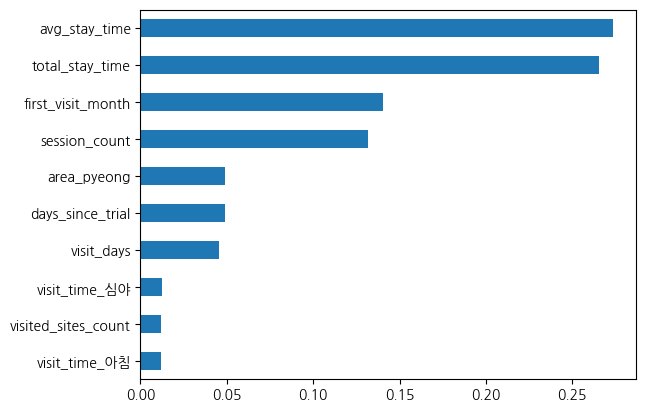

In [59]:
# 역순으로 그려서 가장 큰 값이 위로 가도록 설정
top_importances.iloc[::-1].plot(kind='barh')

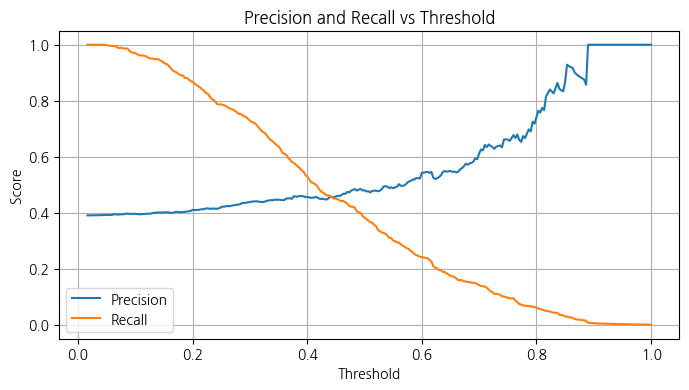

In [60]:
from sklearn.metrics import precision_recall_curve 

y_scores = best_rf.predict_proba(X_test)[:,1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
thresholds = list(thresholds) + [1.0] # 길이 맞추기

plt.figure(figsize=(8,4))
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# threshold = 0.4 실험
# 1. 예측 확률 얻기 (결제자 클래스 확률)
y_proba = best_rf.predict_proba(X_test)[:, 1]  # 클래스 1(결제자)에 대한 확률

# 2. threshold 0.4 적용
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

In [62]:
from sklearn.metrics import classification_report
print('하이퍼파라미터 튜닝 후 결과\n')
print(classification_report(y_test, best_pred))
print('threshold: 0.4 결과 \n')
print(classification_report(y_test, y_pred_threshold))

하이퍼파라미터 튜닝 후 결과

              precision    recall  f1-score   support

           0       0.65      0.73      0.69       696
           1       0.48      0.38      0.42       446

    accuracy                           0.59      1142
   macro avg       0.56      0.56      0.55      1142
weighted avg       0.58      0.59      0.58      1142

threshold: 0.4 결과 

              precision    recall  f1-score   support

           0       0.66      0.60      0.63       696
           1       0.46      0.53      0.49       446

    accuracy                           0.57      1142
   macro avg       0.56      0.56      0.56      1142
weighted avg       0.58      0.57      0.57      1142



#### 랜덤포레스트 - 베이지안 최적화

- 수많은 하이퍼파라미터 조합별로 평가하는 데 시간이 오래 걸릴 때 사용 

In [63]:
!pip install bayesian-optimization

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np

# 1. 최적화 대상 함수 정의
def rf_cv(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=2025,
        n_jobs=-1
    )
    # 교차검증 평균 정확도 반환 (여기선 5-fold)
    return cross_val_score(model, X_train, y_train, cv=5, scoring='recall').mean()

# 2. 탐색 범위 지정
param_bounds = {
    'n_estimators': (50, 300),
    'max_depth': (3, 20),
    'min_samples_split': (2, 10),
    'min_samples_leaf': (1, 5)
}

# 3. 베이지안 최적화 실행
optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=2025, verbose=2)
optimizer.maximize(init_points=5, n_iter=20)  # 초기 5회 랜덤 탐색 후 20회 탐색

# 4. 최적 파라미터 출력
print("Best Parameters:", optimizer.max['params'])

|   iter    |  target   | n_esti... | max_depth | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 2         | 0.3381990 | 83.872040 | 18.093478 | 9.4608451 | 2.7822726 |
| 3         | 0.2770481 | 147.05888 | 7.3791394 | 7.2589406 | 2.9704677 |
| 4         | 0.3247364 | 291.05960 | 16.616736 | 5.6416422 | 4.2042323 |
| 5         | 0.3359629 | 60.429493 | 16.080783 | 2.0253689 | 2.1712375 |
| 6         | 0.3505617 | 202.72858 | 18.521465 | 4.4009200 | 1.9943945 |
| 7         | 0.3410112 | 201.91456 | 18.971923 | 4.6923401 | 2.8814117 |
| 8         | 0.3466292 | 207.05561 | 16.139060 | 2.8623544 | 1.0       |
| 9         | 0.3084820 | 201.20776 | 12.549503 | 2.7266132 | 1.0       |
| 10        | 0.3572829 | 206.55995 | 20.0      | 5.8320426 | 1.0       |
| 11        | 0.3325889 | 206.65528 | 16.399606 | 10.0      | 1.0       |
| 12        | 0.3280977 | 207.84669 | 20.0      | 2.0       | 4.7446667 |
| 13        | 0.3527948 | 212.30501 | 

In [65]:
best_params = optimizer.max['params']

rf_best = RandomForestClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    min_samples_split=int(best_params['min_samples_split']),
    min_samples_leaf=int(best_params['min_samples_leaf']),
    random_state=2025,
    n_jobs=-1
)

rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=214, n_jobs=-1,
                       random_state=2025)

In [66]:
from sklearn.metrics import classification_report, confusion_matrix

# 예측 수행
y_pred = rf_best.predict(X_test)

# classification report 출력
print(classification_report(y_test, y_pred))

# (선택) confusion matrix도 함께 보고 싶다면
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       696
           1       0.49      0.39      0.44       446

    accuracy                           0.60      1142
   macro avg       0.57      0.56      0.56      1142
weighted avg       0.59      0.60      0.59      1142

[[513 183]
 [271 175]]


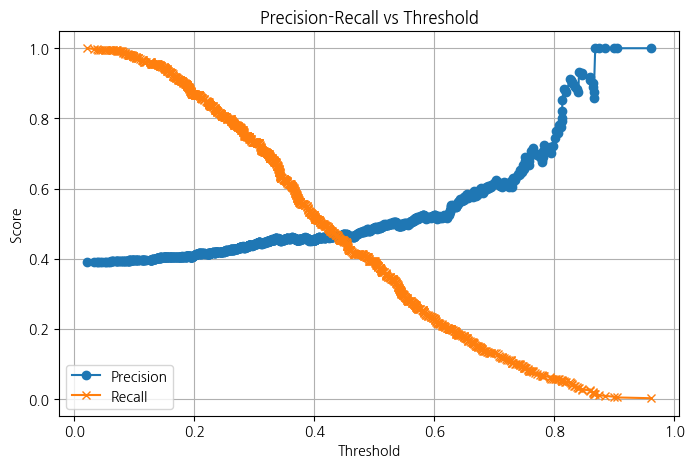

In [67]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
# 예: RandomForestClassifier에서 예측 확률 얻기
y_proba = rf_best.predict_proba(X_test)[:, 1]  # 클래스 1(유료 결제자)일 확률

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", marker='o')
plt.plot(thresholds, recall[:-1], label="Recall", marker='x')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()


In [68]:
# 클래스1의 recall이 0.6 이상임
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_threshold))


              precision    recall  f1-score   support

           0       0.66      0.60      0.63       696
           1       0.45      0.52      0.48       446

    accuracy                           0.57      1142
   macro avg       0.56      0.56      0.56      1142
weighted avg       0.58      0.57      0.57      1142



#### XGBoost - 베이지안 최적화

In [69]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import numpy as np

# X_train, y_train은 사전에 준비된 학습 데이터라고 가정

# 1. 베이지안 최적화를 위한 함수 정의
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, subsample, colsample_bytree):
    model = XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        max_depth=int(max_depth),
        learning_rate=learning_rate,
        n_estimators=int(n_estimators),
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='recall')
    return scores.mean()

# 2. 최적화할 하이퍼파라미터 범위 정의
pbounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'gamma': (0, 5),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1)
}

# 3. 베이지안 최적화 실행
optimizer = BayesianOptimization(
    f=xgb_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=25)  # 초기 5회 랜덤 → 25회 최적화

# 4. 최적 하이퍼파라미터 확인
print("최적 파라미터:", optimizer.max['params'])

|   iter    |  target   | max_depth | learni... | n_esti... |   gamma   | subsample | colsam... |
-------------------------------------------------------------------------------------------------
| 2         | 0.3174395 | 5.6217808 | 0.2857071 | 232.99848 | 2.9932924 | 0.5780093 | 0.5779972 |
| 3         | 0.3185647 | 3.4065852 | 0.2611910 | 200.27875 | 3.5403628 | 0.5102922 | 0.9849549 |
| 4         | 0.3438021 | 8.8270984 | 0.0715783 | 95.456241 | 0.9170225 | 0.6521211 | 0.7623782 |
| 5         | 0.3589395 | 6.0236151 | 0.0944564 | 202.96322 | 0.6974693 | 0.6460723 | 0.6831809 |
| 6         | 0.3056673 | 6.1924898 | 0.2377010 | 99.918445 | 2.5711721 | 0.7962072 | 0.5232252 |
| 7         | 0.3477246 | 8.6587814 | 0.1099882 | 253.18251 | 1.6944671 | 0.7126072 | 0.6976953 |
| 8         | 0.3286610 | 4.5304295 | 0.1142228 | 151.63796 | 1.2576408 | 0.7279349 | 0.8834803 |
| 9         | 0.3802648 | 7.1053614 | 0.2944503 | 96.627588 | 0.5355078 | 0.7626461 | 0.5797710 |
| 10        | 0.3825

In [70]:
best_params = optimizer.max['params']
model = XGBClassifier(
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate'],
    n_estimators=int(best_params['n_estimators']),
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
model.fit(X_train, y_train)


/opt/anaconda3/envs/codeit_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:50:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7002285543964225, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.27044905149971354, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=95, n_jobs=None,
              num_parallel_tree=None, ...)

In [71]:
# 예측 수행
xg_pred_b = model.predict(X_test)

# classification report 출력
print(classification_report(y_test, xg_pred_b))

# confusion matrix도 함께 보고 싶다면
print(confusion_matrix(y_test, xg_pred_b))

              precision    recall  f1-score   support

           0       0.65      0.74      0.70       696
           1       0.49      0.39      0.43       446

    accuracy                           0.60      1142
   macro avg       0.57      0.57      0.56      1142
weighted avg       0.59      0.60      0.59      1142

[[517 179]
 [273 173]]


In [72]:
from sklearn.metrics import classification_report

# 예측 확률 (클래스 1에 대한 확률)
xg_probs = model.predict_proba(X_test)[:, 1]

threshold = 0.4
xg_pred_adjusted = (xg_probs >= threshold).astype(int)

# 평가
print(classification_report(y_test, xg_pred_adjusted))

              precision    recall  f1-score   support

           0       0.68      0.60      0.63       696
           1       0.47      0.56      0.51       446

    accuracy                           0.58      1142
   macro avg       0.57      0.58      0.57      1142
weighted avg       0.60      0.58      0.59      1142



## 5. 클러스터링

- 고객 행동 특성별 유료 결제 전환율 높이기 위한 마케팅 전략 제시하기 위함

In [73]:
from sklearn.cluster import KMeans

In [74]:
# 클러스터링
kmeans = KMeans(
    n_clusters=3,
    init='k-means++',
    max_iter=300,
    random_state=9
)

In [75]:
clustering_df = user_df.drop(columns=['user_uuid','visit_time_심야','visit_time_아침','visit_time_오후','visit_time_저녁'])
clustering_df2 = clustering_df.drop(columns=['is_payment'])
clustering_df2.tail(2)

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,first_visit_month
5705,52855,17618.333333,3,1,10,1,150,4
5706,6976,6976.000000,1,1,3,1,150,1


### 5-1 Feature Scaling - StadardScaler

In [76]:
clustering_df.describe()

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,is_payment,first_visit_month
count,5707.000000,5707.000000,5707.000000,5707.000000,5707.000000,5707.000000,5707.000000,5707.000000,5707.000000
mean,29971.822323,15664.571783,1.787104,1.056422,4.993517,0.922026,111.091642,0.390573,7.230769
std,25614.484166,10113.489133,0.820814,0.262718,4.387407,3.443152,42.151021,0.487922,3.401127
min,9.000000,9.000000,1.000000,1.000000,1.000000,-1.000000,50.000000,0.000000,1.000000
25%,10904.500000,8246.500000,1.000000,1.000000,2.000000,0.000000,50.000000,0.000000,5.000000
50%,22548.000000,14354.000000,2.000000,1.000000,4.000000,1.000000,100.000000,0.000000,8.000000
75%,42368.000000,21217.000000,2.000000,1.000000,7.000000,1.000000,150.000000,1.000000,10.000000
max,249203.000000,81464.000000,4.000000,4.000000,40.000000,201.000000,150.000000,1.000000,12.000000


In [77]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(clustering_df2)

- 클러스터링은 거리 기반이기 때문에 데이터 단위 맞추기 위해 StandardScaler 적용

In [78]:
cluster = kmeans.fit_predict(X_scaled)

In [79]:
cluster

array([0, 2, 2, ..., 1, 2, 0], dtype=int32)

In [80]:
# 군집별 크기 확인
counts = np.bincount(cluster)
counts

array([2296, 1779, 1632])

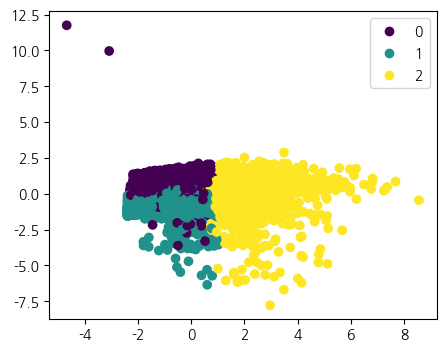

In [81]:
from sklearn.decomposition import PCA

# 2차원 PCA로 차원 축소하여 시각화
pca = PCA(n_components=2, random_state=9)
X_pca = pca.fit_transform(X_scaled)

x = X_pca[:, 0]
y = X_pca[:, 1]

plt.figure(figsize=(5, 4))
scatter = plt.scatter(x, y, c=cluster, cmap='viridis')
handles, labels = scatter.legend_elements()

plt.legend(handles, labels)
plt.show()

In [82]:
# Elbow 기법

inertia = []
K_range = range(1, 11)  # k 1부터 10까지

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=9,
    )
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

In [83]:
kmeans.inertia_

14982.328512754397

In [84]:
inertia

[45656.000000000015,
 35208.73551164367,
 31792.824025556736,
 26384.41591663968,
 21734.007065275677,
 19920.672511383586,
 18570.037369212732,
 16775.289805967972,
 15857.966718848165,
 14982.328512754397]

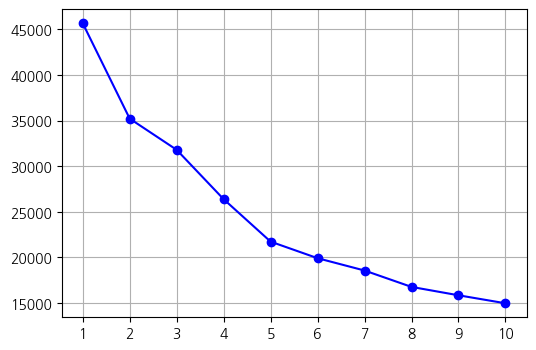

In [85]:
# Elbow 차트 그리기
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, 'bo-')
plt.grid(True)
plt.xticks(K_range)
plt.show()

In [86]:
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples
    )

In [87]:
# 모델 학습
labels = kmeans.fit_predict(X_scaled)

In [88]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"K={k}, silhouette={score:.3f}")


K=2, silhouette=0.290
K=3, silhouette=0.187
K=4, silhouette=0.213
K=5, silhouette=0.196
K=6, silhouette=0.193
K=7, silhouette=0.196
K=8, silhouette=0.197
K=9, silhouette=0.215
K=10, silhouette=0.213


In [89]:
clustering_df['cluster'] = cluster

In [90]:
cluster_summary = clustering_df.groupby('cluster').mean()
cluster_summary

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,is_payment,first_visit_month
cluster,,,,,,,,,
0,16661.918990,12084.416892,1.423345,1.018293,3.460366,1.100610,141.223868,0.394599,6.424216
1,17696.848791,12036.299747,1.497470,1.047218,2.897133,0.921866,65.486228,0.372681,8.298482
2,62077.653186,24656.441626,2.614583,1.120098,9.435662,0.670956,118.412990,0.404412,7.201593


In [91]:
cluster_description = clustering_df.groupby('cluster').describe()
cluster_description

total_stay_time                                                 \
                  count          mean           std      min       25%   
cluster                                                                  
0                2296.0  16661.918990  10462.599463     21.0   8059.75   
1                1779.0  17696.848791  11840.283410      9.0   8182.50   
2                1632.0  62077.653186  23309.754289  20195.0  46122.75   

                                     avg_stay_time                ...  \
             50%       75%       max         count          mean  ...   
cluster                                                           ...   
0        15135.0  24181.25   51582.0        2296.0  12084.416892  ...   
1        15761.0  24878.50   57304.0        1779.0  12036.299747  ...   
2        56967.5  73740.75  249203.0        1632.0  24656.441626  ...   

        is_payment      first_visit_month                                     \
               75%  max             count      mean       std  min  25%  50%   
cluster                                                                        
0              1.0  1.0            2296.0  6.424216  3.462895  1.0  3.0  6.0   
1              1.0  1.0            1779.0  8.298482  3.066979  1.0  7.0  9.0   
2              1.0  1.0            1632.0  7.201593  3.343843  1.0  5.0  8.0   

                     
          75%   max  
cluster              
0         9.0  12.0  
1        11.0  12.0  
2        10.0  12.0  

[3 rows x 72 columns]

In [92]:
clustering_df.groupby('cluster')['is_payment'].mean()

cluster
0    0.394599
1    0.372681
2    0.404412
Name: is_payment, dtype: float64

In [93]:
clustering_df['cluster'].value_counts().sort_index()

cluster
0    2296
1    1779
2    1632
Name: count, dtype: int64

### 5-2 GMM(Gaussian Mixture Model) 클러스터링

- 클러스터에 속할 확률(soft clustering)에 기반한 유연한 군집화 가능 

In [94]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


gmm = GaussianMixture(
    n_components=3,
    random_state=30
)

In [95]:
clustering_df2.tail(2)

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,first_visit_month
5705,52855,17618.333333,3,1,10,1,150,4
5706,6976,6976.000000,1,1,3,1,150,1


In [96]:
gmm.fit(X_scaled)

GaussianMixture(n_components=3, random_state=30)

In [97]:
clustering_df2

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,first_visit_month
0,21417,21417.000000,1,1,3,1,150,9
1,45569,15189.666667,3,1,9,1,150,9
2,77372,38686.000000,2,1,8,1,150,11
3,25024,12512.000000,2,1,4,1,50,1
4,23609,11804.500000,2,1,5,1,150,9
...,...,...,...,...,...,...,...,...
5702,34585,17292.500000,2,1,4,2,50,5
5703,29613,14806.500000,2,1,5,1,100,4
5704,8450,8450.000000,1,1,2,0,100,11
5705,52855,17618.333333,3,1,10,1,150,4


In [98]:
clustering_df['gmm_label'] = gmm.predict(X_scaled)

In [99]:
# 클러스터 소속 확률 확인
proba = gmm.predict_proba(X_scaled)
proba

array([[2.35671169e-03, 6.21869608e-08, 9.97643226e-01],
       [9.35388309e-05, 3.17336355e-08, 9.99906429e-01],
       [3.65047125e-03, 1.14761138e-05, 9.96338053e-01],
       ...,
       [9.99999975e-01, 2.46602604e-08, 0.00000000e+00],
       [1.04091984e-04, 5.38857448e-08, 9.99895854e-01],
       [9.15512262e-04, 3.61795331e-09, 9.99084484e-01]])

In [100]:
# 각 샘플이 가장 높은 확률을 가진
# 컴포넌트 확률만 추출
clustering_df['cluster_proba'] = proba.max(axis=1)

In [101]:
clustering_df.tail(2)

,total_stay_time,avg_stay_time,visit_days,visited_sites_count,session_count,days_since_trial,area_pyeong,is_payment,first_visit_month,cluster,gmm_label,cluster_proba
5705,52855,17618.333333,3,1,10,1,150,0,4,2,2,0.999896
5706,6976,6976.000000,1,1,3,1,150,0,1,0,2,0.999084


In [102]:
clustering_df['gmm_label'].value_counts()

gmm_label
0    2688
2    2646
1     373
Name: count, dtype: int64

In [103]:
clustering_df.groupby('gmm_label')['is_payment'].mean()

gmm_label
0    0.375372
1    0.450402
2    0.397581
Name: is_payment, dtype: float64

In [104]:
from sklearn.decomposition import PCA

- 6개의 주성분으로 GMM 클러스터링

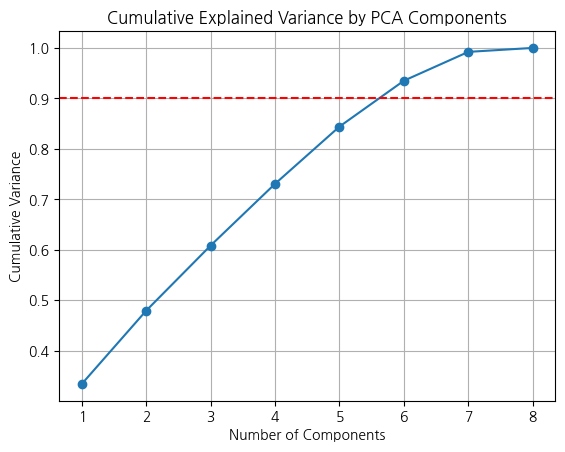

In [105]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 누적 설명력 계산
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 시각화
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.grid()
plt.show()

In [106]:
# 1. PCA로 차원 축소
pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# 2. GMM 적용
gmm = GaussianMixture(n_components=3, random_state=42)
labels = gmm.fit_predict(X_pca)

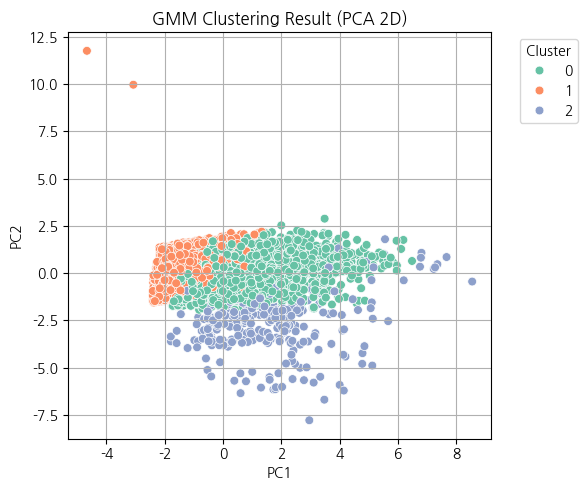

In [107]:
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1],
                hue=labels, palette='Set2', s=40)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('GMM Clustering Result (PCA 2D)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [108]:
pca.explained_variance_ratio_

array([0.3342398 , 0.14526887, 0.12897182, 0.12229594, 0.11338553,
       0.09087011])

In [109]:
# 클러스터별 개수
cluster_counts = pd.Series(labels).value_counts().sort_index()
print(cluster_counts)

0    2946
1    2460
2     301
Name: count, dtype: int64


In [110]:
clustering_df['gmm_label'] = labels

In [111]:
clustering_df['gmm_label'].value_counts()

gmm_label
0    2946
1    2460
2     301
Name: count, dtype: int64

In [112]:
clustering_df.groupby('gmm_label')['is_payment'].mean()

gmm_label
0    0.438561
1    0.321138
2    0.488372
Name: is_payment, dtype: float64

In [113]:
clustering_df.groupby('gmm_label').mean().T

gmm_label,0,1,2
total_stay_time,42980.687712,12560.499187,44947.694352
avg_stay_time,18193.789749,12553.080488,16339.629790
visit_days,2.375085,1.000407,2.461794
visited_sites_count,1.000000,1.000000,2.069767
session_count,6.512559,2.710163,8.787375
days_since_trial,0.797013,1.104065,0.657807
area_pyeong,113.849287,109.369919,98.172757
is_payment,0.438561,0.321138,0.488372
first_visit_month,7.175492,7.297154,7.229236
cluster,1.201629,0.429675,1.481728
